# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

At the end of this project, I'll have an application that can be trained on any set of labeled images. Here the network will be learning about flowers and end up as a command line application.

In [7]:
# Imports here
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Check GPU is Available and Prepare for Using GPU
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.is_available())

1
0
NVIDIA GeForce GTX 1050
True


## Load the data

We use `torchvision` to load the data [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we apply transformations such as random scaling, cropping, and flipping. This helps the network generalize leading to better performance. 

Pre-trained networks trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1. 

In [9]:
#Define data pathway
data_dir = 'C:/Users/lukea/Programming Data/udacity-final-project-flower'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
overfit_dir = data_dir + '/overfit'

#Define image size
image_1d_size = 224
image_2d_size = image_1d_size**2
image_3d_size = image_2d_size*3

In [194]:
#Define transforms for training, validation, overfitting, and test sets to convert to desirable tensors for processing
train_transform = transforms.Compose([transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(image_1d_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                     transforms.CenterCrop(image_1d_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                     transforms.CenterCrop(image_1d_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

game_transform = transforms.Compose([transforms.Resize(int(np.round_(image_1d_size*1.1, decimals=0))),
                                     transforms.CenterCrop(image_1d_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
                                        transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1])])

overfit_transform = train_transform

#Create datasets and transform them with defined transforms above
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform) 
test_data = datasets.ImageFolder(test_dir, transform=test_transform) 
overfit_data = datasets.ImageFolder(overfit_dir, transform=overfit_transform) 
game_data = datasets.ImageFolder(test_dir, transform=game_transform)

#Turn datasets into generators that can be accessed by an iterator or loop
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
overfit_loader = torch.utils.data.DataLoader(overfit_data, batch_size=8, shuffle=True)
game_loader = torch.utils.data.DataLoader(game_data, batch_size=2, shuffle=True)

### Label mapping

Load in a mapping from category label to category name using the file `cat_to_name.json`. It's a JSON object which can be read in with the [`json` module](https://docs.python.org/2/library/json.html). This yields a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [17]:
import json

with open('cat_to_name.json', 'r') as f:
    flower_name_dic = json.load(f)

#Create file pathway for hyperparameter saving to JSON format later
file_hyperparameters = 'flower-classifier-googlenet-hyperparameters.json'

# Building and training the classifier

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters
* Save best hyperparameters to use as default values in the next part of the project.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([256, 150528])
torch.Size([64, 150528])
torch.Size([256])
torch.Size([64])
102


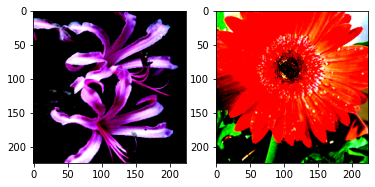

In [12]:
#Create training and validation image iterators to cycle through
train_images, train_labels = next(iter(train_loader))
valid_images, valid_labels = next(iter(valid_loader))

#Print class and label information to understand data structure
print(train_images.shape)
print(valid_images.shape)
print(train_images.view(train_images.shape[0], -1).shape)
print(valid_images.view(valid_images.shape[0], -1).shape)
print(train_labels.shape)
print(valid_labels.shape)
print(len(train_data.classes))

#Plot an example image from valid set and training set
plt.subplot(1, 2, 1)
plt.imshow(train_images[0].numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(valid_images[0].numpy().transpose((1, 2, 0)))

In [13]:
#Check data classes and labels
for i in train_data.classes:
    print([i ,flower_name_dic[i]])
    
print(train_labels)
print(test_labels)

['1', 'pink primrose']
['10', 'globe thistle']
['100', 'blanket flower']
['101', 'trumpet creeper']
['102', 'blackberry lily']
['11', 'snapdragon']
['12', "colt's foot"]
['13', 'king protea']
['14', 'spear thistle']
['15', 'yellow iris']
['16', 'globe-flower']
['17', 'purple coneflower']
['18', 'peruvian lily']
['19', 'balloon flower']
['2', 'hard-leaved pocket orchid']
['20', 'giant white arum lily']
['21', 'fire lily']
['22', 'pincushion flower']
['23', 'fritillary']
['24', 'red ginger']
['25', 'grape hyacinth']
['26', 'corn poppy']
['27', 'prince of wales feathers']
['28', 'stemless gentian']
['29', 'artichoke']
['3', 'canterbury bells']
['30', 'sweet william']
['31', 'carnation']
['32', 'garden phlox']
['33', 'love in the mist']
['34', 'mexican aster']
['35', 'alpine sea holly']
['36', 'ruby-lipped cattleya']
['37', 'cape flower']
['38', 'great masterwort']
['39', 'siam tulip']
['4', 'sweet pea']
['40', 'lenten rose']
['41', 'barbeton daisy']
['42', 'daffodil']
['43', 'sword lily']

NameError: name 'test_labels' is not defined

In [176]:
#Download a pretrained convolutional neural network to reference
model = models.googlenet(pretrained=True)

#Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.weight.shape[1]
out_features = len(train_data.classes)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [209]:
#Create a Classifier class, inheriting from nn.Module and incorporating Relu, Dropout and log_softmax
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.fc2 = nn.Linear(512, out_features)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

#Define the criterion
criterion = nn.NLLLoss()

#Replace the fully connected layer(s) at the end of the model with our own fully connected classifier
model.fc = Classifier()

#Define learning rate and weight decay
learnrate=0.003
weightdecay=0.00001
startlearn=learnrate

# Only train the classifier (fc) parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=learnrate, weight_decay=weightdecay)

#Initialize testing loss history
training_loss_history, validate_loss_history, testing_loss_history, overfit_loss_history = [], [], [], []

#Initialize tracker for activating CNN layers
running_count = 0

model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# Loading checkpoint

loaded model learnrate =  0.000139968


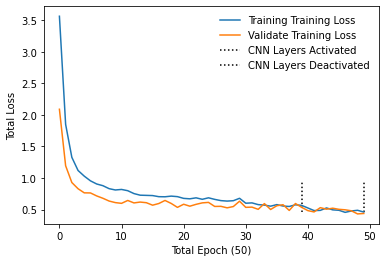

In [166]:
# Option to reload from previous state
checkpoint = torch.load('flower-classifier-googlenet-dict.pth')
model.load_state_dict(checkpoint)

with open(file_hyperparameters, 'r') as file:
    model_hyperparameters = json.load(file)
    
learnrate = model_hyperparameters['learnrate']
training_loss_history = model_hyperparameters['training_loss_history']
validate_loss_history = model_hyperparameters['validate_loss_history']
epoch_on = model_hyperparameters['epoch_on']
running_count = model_hyperparameters['running_count']

print('loaded model learnrate = ', learnrate)
plt.plot(training_loss_history, label='Training Training Loss')
plt.plot(validate_loss_history, label='Validate Training Loss')
plt.vlines(
    colors = 'black',
    x = epoch_on, 
    ymin = min(training_loss_history), 
    ymax = max(training_loss_history[5:]), 
    linestyles = 'dotted', 
    label = 'CNN Layers Activated'
).set_clip_on(False)
plt.vlines(
    colors = 'black',
    x = epoch_on + running_count, 
    ymin = min(training_loss_history), 
    ymax = max(training_loss_history[5:]), 
    linestyles = 'dotted', 
    label = 'CNN Layers Deactivated'
).set_clip_on(False)
plt.ylabel('Total Loss')
plt.xlabel('Total Epoch ({})'.format(len(training_loss_history)))
plt.legend(frameon=False)

# Overfit

Using GPU
Epoch: 1/200..  Overfit Train Loss: 4.6288..  0 of 8 Correct
Epoch: 2/200..  Overfit Train Loss: 3.4418..  0 of 8 Correct
Epoch: 3/200..  Overfit Train Loss: 2.1118..  3 of 8 Correct
Epoch: 4/200..  Overfit Train Loss: 1.2799..  6 of 8 Correct
Epoch: 5/200..  Overfit Train Loss: 1.1766..  5 of 8 Correct
Epoch: 6/200..  Overfit Train Loss: 1.1433..  5 of 8 Correct
Epoch: 7/200..  Overfit Train Loss: 0.9367..  6 of 8 Correct
Epoch: 8/200..  Overfit Train Loss: 0.3906..  8 of 8 Correct
Epoch: 9/200..  Overfit Train Loss: 0.3429..  8 of 8 Correct
Epoch: 10/200..  Overfit Train Loss: 0.3229..  8 of 8 Correct
Epoch: 11/200..  Overfit Train Loss: 0.4159..  7 of 8 Correct

Learnrate changed to: 0.002700

Epoch: 12/200..  Overfit Train Loss: 0.1216..  8 of 8 Correct
Epoch: 13/200..  Overfit Train Loss: 0.7144..  7 of 8 Correct

Learnrate changed to: 0.002430

Epoch: 14/200..  Overfit Train Loss: 0.0940..  8 of 8 Correct
Epoch: 15/200..  Overfit Train Loss: 0.7137..  4 of 8 Correct
Epo

Epoch: 116/200..  Overfit Train Loss: 0.0003..  8 of 8 Correct
Epoch: 117/200..  Overfit Train Loss: 0.0020..  8 of 8 Correct
Epoch: 118/200..  Overfit Train Loss: 0.0002..  8 of 8 Correct
Epoch: 119/200..  Overfit Train Loss: 0.0001..  8 of 8 Correct
Epoch: 120/200..  Overfit Train Loss: 0.0021..  8 of 8 Correct
Epoch: 121/200..  Overfit Train Loss: 0.0014..  8 of 8 Correct
Epoch: 122/200..  Overfit Train Loss: 0.0009..  8 of 8 Correct
Epoch: 123/200..  Overfit Train Loss: 0.0143..  8 of 8 Correct

Learnrate changed to: 0.000127

Epoch: 124/200..  Overfit Train Loss: 0.0096..  8 of 8 Correct

Learnrate changed to: 0.000114

Epoch: 125/200..  Overfit Train Loss: 0.0054..  8 of 8 Correct
Epoch: 126/200..  Overfit Train Loss: 0.0004..  8 of 8 Correct
Epoch: 127/200..  Overfit Train Loss: 0.0007..  8 of 8 Correct
Epoch: 128/200..  Overfit Train Loss: 0.0026..  8 of 8 Correct
Epoch: 129/200..  Overfit Train Loss: 0.0006..  8 of 8 Correct
Epoch: 130/200..  Overfit Train Loss: 0.0000..  8 of

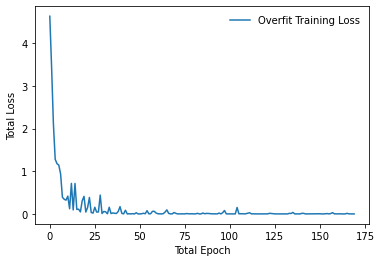

In [208]:
# Check model can overfit the data when using a miniscule sample size, looking for high accuracy on a few images
print("Using GPU" if torch.cuda.is_available() else "WARNING")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)


t0 = time.time() # initialize start time for running training

running_count = 0 # initialize running count in order to track number of epochs fine tuning deeper network
running = False # initialize running variable to start system with deeper network frozen

decay = 0.9 # hyperparameter decay factor for decaying learning rate
epochs = 200 # hyperparameter number of epochs


for e in range(epochs):
    
    for overfit_images, overfit_labels in overfit_loader: # grab the overfit data
        overfit_images, overfit_labels = overfit_images.to(device), overfit_labels.to(device) # move data to GPU

        epoch_overfit_loss = 0 # initialize total loss for this epoch
        optimizer.zero_grad() # clear gradient history
        log_out = model(overfit_images) # run image through model to get logarithmic probability
        loss = criterion(log_out, overfit_labels) # calculate loss (error) for this image batch based on criterion

        loss.backward() # backpropogate gradients through model based on error
        optimizer.step() # update weights in model based on calculated gradient information
        epoch_overfit_loss += loss.item() # add overfit training loss to total train loss this epoch, convert to value with .item()

    ave_overfit_loss = epoch_overfit_loss / len(overfit_loader) # determine average loss per batch of training images
    overfit_loss_history.append(ave_overfit_loss) # append ave training loss to history of training losses

    out = torch.exp(log_out)
    highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greavalid calculated probability
    equals = chosen_class.view(overfit_labels.shape) == overfit_labels # determine how many correct matches were made in this batch
    overfit_count_correct = equals.sum()  # add the count of correct matches this batch to the total running this epoch
    
    print('Epoch: {}/{}.. '.format(e+1, epochs),
        'Overfit Train Loss: {:.4f}.. '.format(ave_overfit_loss),
         '{:.0f} of {:.0f} Correct'.format(overfit_count_correct, len(overfit_labels)))
    
    if len(overfit_loss_history) > 3: # hold loop until training_loss_history has enough elements to satisfy search requirements
        if -3*learnrate*decay*decay*overfit_loss_history[0] > np.mean([overfit_loss_history[-2]-overfit_loss_history[-1], overfit_loss_history[-3]-overfit_loss_history[-2]]):
            # if the average of the last 2 training loss slopes is less than the original loss factored down by the learnrate, the decay, and a factor of 3, then decay the learnrate
            learnrate *= decay # multiply learnrate by the decay hyperparamater
            optimizer = optim.Adam(model.fc.parameters(), lr=learnrate, weight_decay=weightdecay) # revise the optimizer to use the new learnrate
            print('\nLearnrate changed to: {:f}\n'.format(learnrate))
        if learnrate <= startlearn*decay**(9*(decay**3)) and running_count == 0: # super messy, I wanted a general expression that chose when to activate the deeper network and this worked
            for param in model.inception5a.parameters(): # activate parameters in layer 5a once the learning rate has decayed (9*(decay**3)) number of times
                param.requires_grad = True
            for param in model.inception5b.parameters(): # activate parameters in layer 5b once the learning rate has decayed (9*(decay**3)) number of times
                param.requires_grad = True
            print('Convolutional Layers I5A and I5B Training Activated\n')
            running = True # change the running parameter to True so that the future loop can start counting epochs that have run
        if running: # if running, add to count for the number of epochs run
            running_count +=1
        if running and running_count > epochs/5: # deactivate parameters if running, add the count has reached its limiter
            for param in model.inception5a.parameters():
                param.requires_grad = False  
            for param in model.inception5b.parameters():
                param.requires_grad = False  
            print('\nConvolutional Layers I5A and I5B Training Deactivated\n')
            running = False
        if np.mean([overfit_loss_history[-1], overfit_loss_history[-2], overfit_loss_history[-3]]) < 0.0001:
            print('\nModel successfully overfit images')
            break
        
    model.train()
    
    if e+1 == epochs:
        print('\nModel failed to overfit images')

print('\nRuntime - {:.0f} seconds'.format((time.time() - t0)))
plt.plot(overfit_loss_history, label='Overfit Training Loss')
plt.ylabel('Total Loss')
plt.xlabel('Total Epoch')
plt.legend(frameon=False)

# Short

In [163]:
# Check model can successfully run 10 batches before running entire model, also great for watching performance
print("Using GPU" if torch.cuda.is_available() else "WARNING")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)

t0 = time.time()

epochs = 1

for e in range(epochs):
    
    train_images, train_labels = next(iter(train_loader)) # grab one batch of training data
    valid_images, valid_labels = next(iter(valid_loader)) # grab one batch of validation data
    
    train_images, train_labels = train_images.to(device), train_labels.to(device) # move data to GPU
    
    epoch_train_loss = 0 # initialize total training loss for this epoch
    optimizer.zero_grad() # clear gradient history
    log_out = model(train_images) # run image through model to get logarithmic probability
    loss = criterion(log_out, train_labels) # calculate loss (error) for this image batch based on criterion

    loss.backward() # backpropogate gradients through model based on error
    optimizer.step() # update weights in model based on calculated gradient information
    epoch_train_loss += loss.item() # add training loss to total train loss this epoch, convert to value with .item()

    epoch_valid_loss = 0 # initialize total validation loss for this epoch
    valid_count_correct = 0 # initialize total correct predictions on valid set
    with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
        valid_images, valid_labels = valid_images.to(device), valid_labels.to(device) # move data to GPU
        log_out = model(valid_images) # obtain the logarithmic probability from the model
        loss = criterion(log_out, valid_labels) # calculate loss (error) for this image batch based on criterion
        epoch_valid_loss += loss.item() # add validation loss to total valid loss this epoch, convert to value with .item()

        out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
        highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greavalid calculated probability
        equals = chosen_class.view(valid_labels.shape) == valid_labels # determine how many correct matches were made in this batch
        valid_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch

        ave_training_loss = epoch_train_loss / len(train_loader) # determine average loss per batch of training images
        ave_validate_loss = epoch_valid_loss / len(valid_loader) # determine average loss per batch of validation images  
    
    model.train() # reactivate training
    print('Epoch: {}/{}.. '.format(e+1, epochs),
        'Train Loss: {:.4f}.. '.format(ave_training_loss),
        'Valid Loss: {:.4f}.. '.format(ave_validate_loss),
        '{:.0f} of {:.0f} Correct'.format(valid_count_correct, len(valid_labels)))

print('Correct Labels: ',valid_labels.tolist())
print('Chosen Labels:  ',chosen_class.view(valid_labels.shape).tolist())
print('Runtime - {:.0f} seconds'.format((time.time() - t0)))

Using GPU
Epoch: 1/2..  Train Loss: 0.0254..  Valid Loss: 0.0441..  53 of 64 Correct
Epoch: 2/2..  Train Loss: 0.0207..  Valid Loss: 0.0436..  55 of 64 Correct
Correct Labels:  [2, 56, 55, 10, 99, 29, 62, 67, 94, 11, 98, 100, 89, 49, 4, 89, 43, 68, 79, 88, 90, 53, 77, 9, 75, 83, 40, 32, 50, 40, 3, 81, 100, 11, 38, 49, 41, 49, 59, 45, 84, 50, 85, 98, 93, 29, 71, 82, 90, 11, 54, 75, 69, 76, 92, 71, 26, 95, 3, 2, 49, 42, 60, 39]
Chosen Labels:   [2, 56, 55, 10, 99, 29, 62, 67, 94, 11, 98, 49, 89, 49, 4, 89, 43, 68, 5, 32, 90, 53, 77, 9, 75, 83, 40, 32, 50, 40, 3, 81, 100, 11, 48, 49, 41, 49, 59, 45, 40, 50, 66, 98, 93, 29, 71, 82, 90, 11, 54, 75, 82, 76, 92, 71, 48, 23, 3, 2, 49, 42, 60, 39]
Runtime - 11 seconds


# Train

In [211]:
print("Using GPU" if torch.cuda.is_available() else "WARNING")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)

t0 = time.time() # initialize start time for running training

running = False # initialize running variable to start system with deeper network frozen

decay = 0.6 # hyperparameter decay factor for decaying learning rate
epochs = 100 # hyperparameter number of epochs

for e in range(epochs):
    model.train()
    epoch_train_loss = 0 # initialize total training loss for this epoch
    for train_images, train_labels in train_loader: # cycle through training data
        train_images, train_labels = train_images.to(device), train_labels.to(device) # move data to GPU
        
        optimizer.zero_grad() # clear gradient history
        log_out = model(train_images) # run image through model to get logarithmic probability
        loss = criterion(log_out, train_labels) # calculate loss (error) for this image batch based on criterion

        loss.backward() # backpropogate gradients through model based on error
        optimizer.step() # update weights in model based on calculated gradient information
        epoch_train_loss += loss.item() # add training loss to total train loss this epoch, convert to value with .item()
        
    else:
        epoch_valid_loss = 0 # initialize total validate loss for this epoch
        valid_count_correct = 0 # initialize total correct predictions on valid set
        with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
            for valid_images, valid_labels in valid_loader: # cycle through validate data to observe performance
                valid_images, valid_labels = valid_images.to(device), valid_labels.to(device) # move data to GPU
                log_out = model(valid_images) # obtain the logarithmic probability from the model
                loss = criterion(log_out, valid_labels) # calculate loss (error) for this image batch based on criterion
                epoch_valid_loss += loss.item() # add validate loss to total valid loss this epoch, convert to value with .item()

                out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
                highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greavalid calculated probability
                equals = chosen_class.view(valid_labels.shape) == valid_labels # determine how many correct matches were made in this batch
                valid_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch

            ave_training_loss = epoch_train_loss / len(train_loader) # determine average loss per batch of training images
            ave_validate_loss = epoch_valid_loss / len(valid_loader) # determine average loss per batch of validate images
            training_loss_history.append(ave_training_loss) # append ave training loss to history of training losses
            validate_loss_history.append(ave_validate_loss) # append ave validate loss to history of validate losses
        
        print('Epoch: {}/{}.. '.format(e+1, epochs),
            'Training Loss: {:.3f}.. '.format(ave_training_loss),
            'Validate Loss: {:.3f}.. '.format(ave_validate_loss),
            'Validate Accuracy: {:.3f}'.format(valid_count_correct / len(valid_loader.dataset)),
            'Runtime - {:.0f} minutes'.format((time.time() - t0)/60))
        
        if len(training_loss_history) > 3: # hold loop until training_loss_history has enough elements to satisfy search requirements
            if -3*learnrate*decay*decay*training_loss_history[0] > np.mean([training_loss_history[-2]-training_loss_history[-1], training_loss_history[-3]-training_loss_history[-2]]):
                # if the average of the last 2 training loss slopes is less than the original loss factored down by the learnrate, the decay, and a factor of 3, then decay the learnrate
                learnrate *= decay # multiply learnrate by the decay hyperparamater
                optimizer = optim.Adam(model.fc.parameters(), lr=learnrate, weight_decay=weightdecay) # revise the optimizer to use the new learnrate
                print('\nLearnrate changed to: {:f}\n'.format(learnrate))
            if learnrate <= startlearn*decay**(9*(decay**3)) and running_count == 0: # super messy, I wanted a general expression that chose when to activate the deeper network and this worked
                for param in model.inception5a.parameters(): # activate parameters in layer 5a once the learning rate has decayed (9*(decay**3)) number of times
                    param.requires_grad = True
                for param in model.inception5b.parameters(): # activate parameters in layer 5b once the learning rate has decayed (9*(decay**3)) number of times
                    param.requires_grad = True
                print('\nConvolutional Layers I5A and I5B Training Activated\n')
                epoch_on = e
                running = True # change the running parameter to True so that the future loop can start counting epochs that have run
            if running: # if running, add to count for the number of epochs run
                running_count +=1 
            if running and running_count > epochs/5: # deactivate parameters if running, add the count has reached its limiter
                for param in model.inception5a.parameters():
                    param.requires_grad = False  
                for param in model.inception5b.parameters():
                    param.requires_grad = False  
                print('\nConvolutional Layers I5A and I5B Training Deactivated\n')
                running = False

Using GPU
Epoch: 1/100..  Training Loss: 3.585..  Validate Loss: 2.142..  Validate Accuracy: 0.489 Runtime - 2 minutes
Epoch: 2/100..  Training Loss: 1.857..  Validate Loss: 1.260..  Validate Accuracy: 0.663 Runtime - 4 minutes
Epoch: 3/100..  Training Loss: 1.355..  Validate Loss: 1.011..  Validate Accuracy: 0.727 Runtime - 6 minutes
Epoch: 4/100..  Training Loss: 1.155..  Validate Loss: 0.824..  Validate Accuracy: 0.776 Runtime - 9 minutes
Epoch: 5/100..  Training Loss: 1.016..  Validate Loss: 0.770..  Validate Accuracy: 0.807 Runtime - 11 minutes
Epoch: 6/100..  Training Loss: 0.991..  Validate Loss: 0.683..  Validate Accuracy: 0.802 Runtime - 13 minutes
Epoch: 7/100..  Training Loss: 0.871..  Validate Loss: 0.675..  Validate Accuracy: 0.814 Runtime - 15 minutes
Epoch: 8/100..  Training Loss: 0.882..  Validate Loss: 0.712..  Validate Accuracy: 0.803 Runtime - 17 minutes
Epoch: 9/100..  Training Loss: 0.857..  Validate Loss: 0.633..  Validate Accuracy: 0.829 Runtime - 19 minutes
Epoc

Epoch: 69/100..  Training Loss: 0.499..  Validate Loss: 0.491..  Validate Accuracy: 0.875 Runtime - 146 minutes

Learnrate changed to: 0.000001

Epoch: 70/100..  Training Loss: 0.511..  Validate Loss: 0.459..  Validate Accuracy: 0.879 Runtime - 148 minutes

Learnrate changed to: 0.000000

Epoch: 71/100..  Training Loss: 0.519..  Validate Loss: 0.439..  Validate Accuracy: 0.884 Runtime - 150 minutes

Learnrate changed to: 0.000000

Epoch: 72/100..  Training Loss: 0.515..  Validate Loss: 0.453..  Validate Accuracy: 0.881 Runtime - 152 minutes

Learnrate changed to: 0.000000

Epoch: 73/100..  Training Loss: 0.479..  Validate Loss: 0.414..  Validate Accuracy: 0.886 Runtime - 154 minutes
Epoch: 74/100..  Training Loss: 0.486..  Validate Loss: 0.423..  Validate Accuracy: 0.884 Runtime - 157 minutes
Epoch: 75/100..  Training Loss: 0.494..  Validate Loss: 0.415..  Validate Accuracy: 0.895 Runtime - 159 minutes

Learnrate changed to: 0.000000

Epoch: 76/100..  Training Loss: 0.511..  Validate L

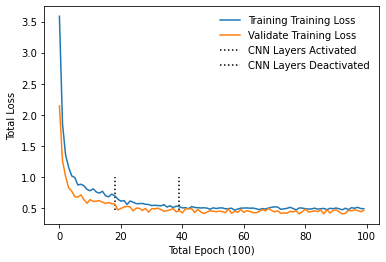

In [212]:
plt.plot(training_loss_history, label='Training Training Loss')
plt.plot(validate_loss_history, label='Validate Training Loss')
plt.vlines(
    colors = 'black',
    x = epoch_on, 
    ymin = min(training_loss_history), 
    ymax = max(training_loss_history[5:]), 
    linestyles = 'dotted', 
    label = 'CNN Layers Activated'
).set_clip_on(False)
plt.vlines(
    colors = 'black',
    x = epoch_on + running_count, 
    ymin = min(training_loss_history), 
    ymax = max(training_loss_history[5:]), 
    linestyles = 'dotted', 
    label = 'CNN Layers Deactivated'
).set_clip_on(False)
plt.ylabel('Total Loss')
plt.xlabel('Total Epoch ({})'.format(len(training_loss_history)))
plt.legend(frameon=False)

## Testing your network

Testing the trained network on images the network has never seen either in training or validation. This is to give an estimate for the model's performance on completely new images.

In [215]:
print("Using GPU" if torch.cuda.is_available() else "WARNING")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)

t0 = time.time()

epochs = 10

for e in range(epochs):
    epoch_test_loss = 0 # initialize total testing loss for this epoch
    test_count_correct = 0 # initialize total correct predictions on test set
    with torch.no_grad(): # turn off gradient tracking and calculation for computational efficiency
        for test_images, test_labels in test_loader: # cycle through testing data to observe performance
            test_images, test_labels = test_images.to(device), test_labels.to(device) # move data to GPU
            log_out = model(test_images) # obtain the logarithmic probability from the model
            loss = criterion(log_out, test_labels) # calculate loss (error) for this image batch based on criterion
            epoch_test_loss += loss.item() # add testing loss to total test loss this epoch, convert to value with .item()

            out = torch.exp(log_out) # obtain probability from the logarithmic probability calculated by the model
            highest_prob, chosen_class = out.topk(1, dim=1) # obtain the chosen classes based on greatest calculated probability
            equals = chosen_class.view(test_labels.shape) == test_labels # determine how many correct matches were made in this batch
            test_count_correct += equals.sum()  # add the count of correct matches this batch to the total running this epoch

        ave_testing_loss = epoch_test_loss / len(test_loader) # determine average loss per batch of testing images

    print('Epoch: {}/{}.. '.format(e+1, epochs),
        'testing Loss: {:.3f}.. '.format(ave_testing_loss),
        'testing Accuracy: {:.3f}'.format(test_count_correct / len(test_loader.dataset)),
        'Runtime - {:.0f} seconds'.format((time.time() - t0)))

Using GPU
Epoch: 1/10..  testing Loss: 0.598..  testing Accuracy: 0.846 Runtime - 14 seconds
Epoch: 2/10..  testing Loss: 0.552..  testing Accuracy: 0.845 Runtime - 28 seconds
Epoch: 3/10..  testing Loss: 0.580..  testing Accuracy: 0.839 Runtime - 41 seconds
Epoch: 4/10..  testing Loss: 0.548..  testing Accuracy: 0.842 Runtime - 55 seconds
Epoch: 5/10..  testing Loss: 0.581..  testing Accuracy: 0.845 Runtime - 68 seconds
Epoch: 6/10..  testing Loss: 0.595..  testing Accuracy: 0.835 Runtime - 81 seconds
Epoch: 7/10..  testing Loss: 0.525..  testing Accuracy: 0.850 Runtime - 94 seconds
Epoch: 8/10..  testing Loss: 0.592..  testing Accuracy: 0.835 Runtime - 107 seconds
Epoch: 9/10..  testing Loss: 0.559..  testing Accuracy: 0.842 Runtime - 121 seconds
Epoch: 10/10..  testing Loss: 0.589..  testing Accuracy: 0.838 Runtime - 134 seconds


# Save Model

In [214]:
#Save the model state_dict
torch.save(model.state_dict(), 'flower-classifier-googlenet-dict.pth')
model.fc.state_dict().keys()

#Save the model hyperparameters and the locations in which the CNN training activated and deactivated
model_hyperparameters = {'learnrate':learnrate, 
                         'training_loss_history': training_loss_history, 
                         'validate_loss_history': validate_loss_history,
                         'epoch_on': epoch_on,
                         'running_count': running_count}

#Create a JSON file containing the saved information above
with open(file_hyperparameters, 'w') as file:
    json.dump(model_hyperparameters, file)

# Game

Left: hippeastrum and Right: grape hyacinth


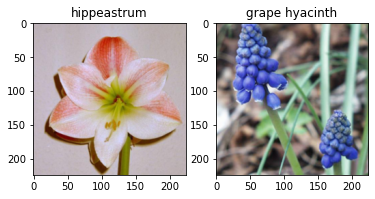

In [428]:
#Predicted images in batches of two!
model.cpu()
game_images, game_labels = next(iter(game_loader)) # Fun to observe flower guesses in batches of two

prediction = torch.exp(model(game_images)) 
highest_prob, predicted_class = prediction.topk(1, dim=1)

flower_prediction = []
for predicted_flower in predicted_class:
    flower_prediction.append([key for key, value in game_data.class_to_idx.items() if value == predicted_flower]) 
flower_answer = []
for correct_flower in game_labels:
    flower_answer.append([key for key, value in game_data.class_to_idx.items() if value == correct_flower])   

print('Left: \033[1m{}\033[0m and Right: \033[1m{}\033[0m'.format(flower_name_dic[flower_prediction[0][0]], flower_name_dic[flower_prediction[1][0]]))

plt.subplot(1, 2, 1)
plt.title(flower_name_dic[flower_answer[0][0]])
plt.imshow(inverse_transform(game_images[0]).numpy().transpose((1, 2, 0))) # Use inverse transform to make the image nicer to look at

plt.subplot(1, 2, 2)
plt.title(flower_name_dic[flower_answer[1][0]])
plt.imshow(inverse_transform(game_images[1]).numpy().transpose((1, 2, 0))) # Use inverse transform to make the image nicer to look at

In [426]:
flower_prediction = []
for predicted_flower in predicted_class:
    flower_prediction.append([key for key, value in game_data.class_to_idx.items() if value == predicted_flower])
    
flower_answer = []
for correct_flower in game_labels:
    flower_answer.append([key for key, value in game_data.class_to_idx.items() if value == correct_flower])   

print(flower_prediction[1], '\n', flower_answer)

['33'] 
 [['95'], ['33']]


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [101]:
#Extra code to index classes for data but it isn't really necessary.

# print(train_data.class_to_idx,'\n')
# print(flower_name_dic,'\n')

# print(train_data.class_to_idx.keys(),'\n')
# print(flower_name_dic.keys(),'\n')
    
# for key in train_data.class_to_idx:
#     train_data.class_to_idx[key] = flower_name_dic[key]
    
# for key in train_data.class_to_idx:
#     print(key)
#     print(train_data.class_to_idx[key])
#     print(flower_name_dic[key])

{'1': 'pink primrose', '10': 'globe thistle', '100': 'blanket flower', '101': 'trumpet creeper', '102': 'blackberry lily', '11': 'snapdragon', '12': "colt's foot", '13': 'king protea', '14': 'spear thistle', '15': 'yellow iris', '16': 'globe-flower', '17': 'purple coneflower', '18': 'peruvian lily', '19': 'balloon flower', '2': 'hard-leaved pocket orchid', '20': 'giant white arum lily', '21': 'fire lily', '22': 'pincushion flower', '23': 'fritillary', '24': 'red ginger', '25': 'grape hyacinth', '26': 'corn poppy', '27': 'prince of wales feathers', '28': 'stemless gentian', '29': 'artichoke', '3': 'canterbury bells', '30': 'sweet william', '31': 'carnation', '32': 'garden phlox', '33': 'love in the mist', '34': 'mexican aster', '35': 'alpine sea holly', '36': 'ruby-lipped cattleya', '37': 'cape flower', '38': 'great masterwort', '39': 'siam tulip', '4': 'sweet pea', '40': 'lenten rose', '41': 'barbeton daisy', '42': 'daffodil', '43': 'sword lily', '44': 'poinsettia', '45': 'bolero deep 